# Feature importance analysis
In this laboratory you will use two different techniques to analyse the relative importance of the dataset features. In the first part, you will use a Random Forest to evaluate the relative importance of the features of the training set. This technique is often used to get rid of irrelevant features before training. In the second step, you will use the feature elimination technique to understand which features contribute most to the classification task.

In [27]:
# Author: Roberto Doriguzzi-Corin
# Project: Lecture on Intrusion Detection with Deep Learning
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import numpy as np
import glob
import h5py
import sys
import copy
import argparse
from sklearn.metrics import f1_score
from tensorflow.keras.models import load_model
import tensorflow as tf
import logging

from sklearn.ensemble import RandomForestClassifier

config = tf.compat.v1.ConfigProto(inter_op_parallelism_threads=1)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel(logging.ERROR)

from matplotlib import pyplot as plt
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

SEED=1
feature_names = ['time','packet_len','highest_proto','IP flags','protocols','TCP len','TCP ack','TCP flags','TCP win_size',
                         'UDP len','ICMP type','flow_len']

In [28]:
def load_dataset(path):
    filename = glob.glob(path)[0]
    dataset = h5py.File(filename, "r")
    set_x_orig = np.array(dataset["set_x"][:])  # features
    set_y_orig = np.array(dataset["set_y"][:])  # labels

    X = np.reshape(set_x_orig, (set_x_orig.shape[0], set_x_orig.shape[1], set_x_orig.shape[2], 1))
    Y = set_y_orig

    return X, Y

In [29]:
def remove_one_feature(X,index):
    X_new = []
    for sample in X:
        new_sample = copy.deepcopy(sample)
        new_sample[index] = 0
        X_new.append(new_sample)
    return np.array(X_new)

## Reshaping the samples
The training samples are two-dimensinal arrays of size 10x11, in which the rows are packets in chronological order (up to 10 packets) and the columns are packet-level features (11 features such as packet length, TCP flags, etc.) ([LUCID representation of the network traffic](https://github.com/doriguzzi/lucid-ddos)). The packets in a sample belong to a single traffic flow as collected within a time window of 10 seconds. If less then 10 packets are collected within a given time window, the sample is zero-padded. Therefore, the number of non-zero rows can be interpreted as an additional feature representing the number of packets collected in a time window for a specific flow.

To evaluate the importance of each traffic feature with Random Forest (including the number of packets), you need first to convert a two-dimensional array into a vector of 12 elements. The first 11 elements are the average value of each packet feature, while the 12th element is the number of packets of the flow (number of non-zero rows). 

In [30]:
def flatten_samples(X_train):
    X_new = []
    for sample in X_train:
        sample = np.squeeze(sample)
        packets_nr = np.count_nonzero(sample.sum(axis=1)) #number of non-zero rows
        new_sample = np.mean(sample,axis=0)  # average value of each packet feature in a sample
        new_sample = np.append(new_sample,[packets_nr],axis=0) 
        X_new.append(new_sample)
    return np.array(X_new)

In [31]:
X_train, Y_train = load_dataset("../Datasets/IDS2017/*" + '-train.hdf5')
X_train = flatten_samples(X_train)

## Feature analysis with Random Forest
Replace code in the cell below with a random forest that estimates the relative importance of each feature in the training set. In this part of the laboratory, you will use a 1D representation of the flows to understand which features are more important for a pre-trained model.

In [32]:
feature_importances_ = np.random.rand(X_train.shape[1]) # replace with a RandomForestClassifier

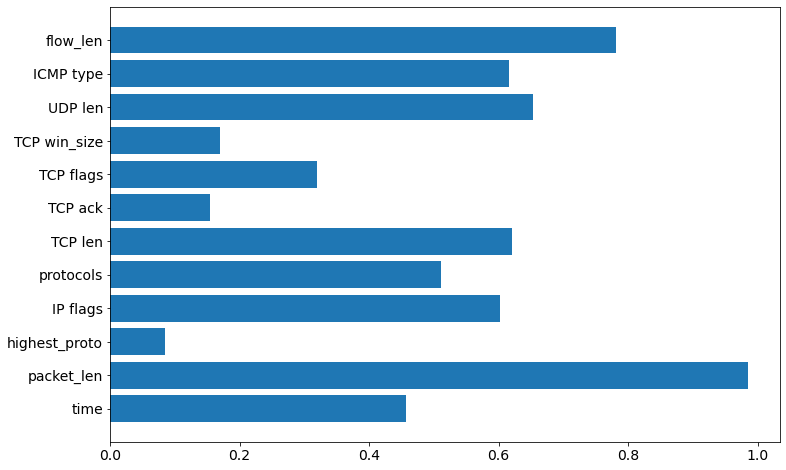

In [33]:
plt.barh(feature_names, feature_importances_)
plt.show()

## Analisys of feature importance with feature elimination
In the cells below, a different feature is removed at each iteration to estimate its importance in the classification task. The analysis is executed on the test set with a pre-trained model.  

In [34]:
X_test, Y_test = load_dataset("../Datasets/IDS2017/*" + '-test.hdf5')
X_test = flatten_samples(X_test)
model = load_model("../Models/10t-1n-mlp-IDS2017.h5")

In [35]:
results = []
for feature in feature_names:
    feature_index = feature_names.index(feature)
    X_test_one_feature = remove_one_feature(X_test,feature_index)
    Y_pred = np.squeeze(model.predict(X_test_one_feature, batch_size=2048) > 0.5) 
    f1 = f1_score(Y_test, Y_pred)
    results.append(1-f1)

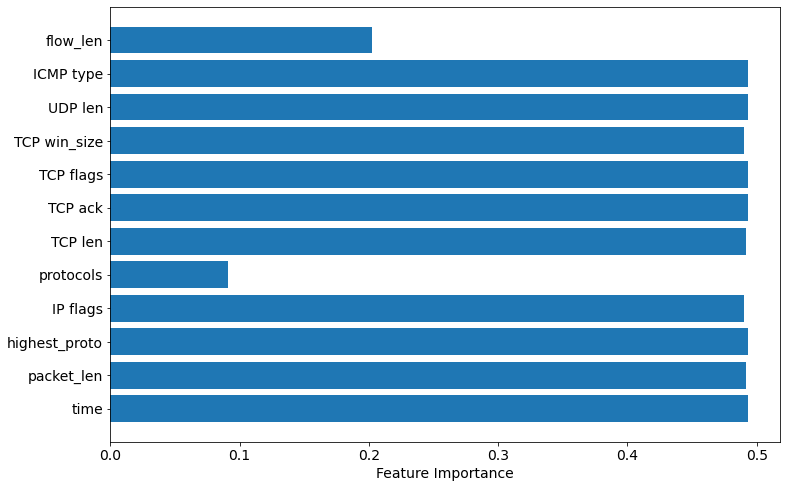

In [36]:
plt.barh(np.array(feature_names), np.array(results))
plt.xlabel("Feature Importance")
plt.show()